In [363]:
import typing as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng()

TFeaturizer = T.Callable[[np.ndarray], np.ndarray]

np.set_printoptions(
    linewidth=180,
    edgeitems=14,
    formatter={
        'float': lambda x: f'{x:6.3}',
    }
)

In [364]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('archive/mnist_train.csv')
train, eval = train_test_split(train_df[train_df.label.isin([0,1])].to_numpy())

# image_data = train_df[train_df.label.isin([0,1])].drop('label',axis=1).to_numpy().reshape((-1,28,28))
# labels = train_df[train_df.label.isin([0,1])].label.to_numpy().reshape(-1)
image_data = train[:,1:].reshape((-1,28,28))
labels = train[:,0].reshape((-1,1))
eval_image_data = eval[:,1:].reshape((-1,28,28))
eval_labels = eval[:,1].reshape((-1,1))

## Show Images

In [365]:
from itertools import chain

def show_images(image_data,rows=3,columns=3):
    fig, axes = plt.subplots(rows,columns)
    for image,ax in zip(rng.choice(image_data, rows*columns), chain(*axes)):
        ax.imshow(image)
    fig.tight_layout()
    return fig, axes

(<Figure size 640x480 with 9 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], dtype=object))

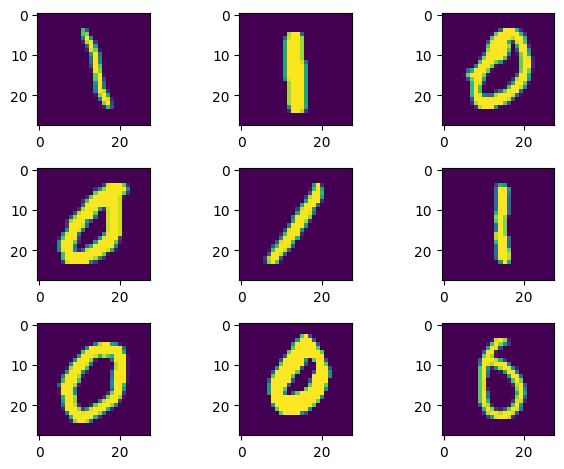

In [366]:
show_images(image_data)

In [455]:
def hist_feature(_image_data: np.ndarray, get_feature: TFeaturizer):
    zero_feature = get_feature(_image_data[labels.reshape(-1) == 0])
    one_feature = get_feature(_image_data[labels.reshape(-1) == 1])

    # display properties
    bins = 30
    alpha = 0.7
    # fig,axes = plt.subplots(1,1)
    plt.hist(zero_feature, bins=bins, alpha=alpha, color="blue", label="zero")
    plt.hist(one_feature, bins=bins, alpha=alpha, color="red", label="one")
    plt.legend()
    plt.xlim(125,135)
    return zero_feature, one_feature


## Feature Experimentation

In [368]:
def ex_get_feature(_image_data: np.ndarray) -> np.ndarray:
    """(-1,28,28) -> (-1,1)"""
    return _image_data.clip(max=1).sum(axis=(1,2))

(array([215, 167, 125, 259, 208, 188, 194, 149, 197, 204, 154, 150, 285, 186, ..., 211, 146, 161, 202, 156, 160, 172, 193, 242, 214, 182, 207, 170, 144], dtype=int64),
 array([ 99,  76, 102,  76,  68,  94,  78,  86, 101,  49, 146,  74,  60, 100, ...,  70,  72, 134, 115,  60,  59,  78,  54,  90,  83,  92,  70,  70,  59], dtype=int64))

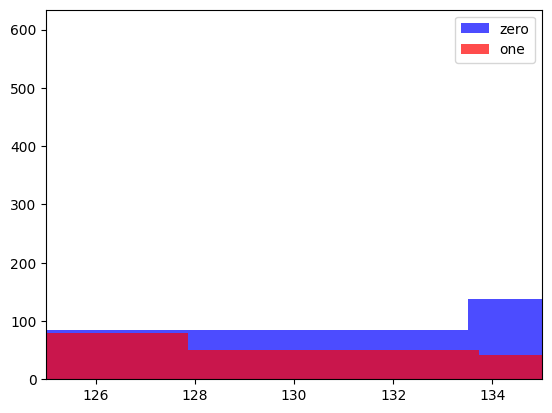

In [456]:
hist_feature(image_data, ex_get_feature)
# ex_get_feature(image_data[:1])
# plt.hist(ex_get_feature(image_data[labels.reshape((-1)) == 0]), bins=30, alpha=.7, color='blue', label='F')


## Features

### Sum Active Cells

In [457]:
def sum_active_cells_featurizer(_image_data: np.ndarray) -> np.ndarray:
    """(-1,28,28) -> (-1,1)"""
    return _image_data.clip(max=1).sum(axis=(1,2))

## Models

In [458]:
class IModel:
    def predict(self, sample) -> np.ndarray:
        ...

### SingleParameterBinaryClassifier

In [459]:
class SingleParameterBinaryClassifier(IModel):
    def __init__(self, parameter: float, featurizer: TFeaturizer, labels: T.Tuple[int]):
        self.parameter = parameter
        self.featurizer = featurizer
        self.labels = labels
    
    def predict(self, sample: np.ndarray, parameter: float = None) -> np.ndarray:
        _parameter = parameter or self.parameter
        return np.where(self.featurizer(sample) < _parameter, self.labels[0], self.labels[1])
    

### Metrics

In [460]:
def accuracy(model: IModel, X: np.ndarray, y: np.ndarray, *args, **kwargs) -> float:
    result = np.sum(model.predict(X, *args, **kwargs) == y.reshape(-1)) / len(y)
    assert result <= 1
    return result

### Optimizers

In [461]:
def random_search(f: T.Callable[[float], float], min: float, max: float, n=1000):
    sample = (max - min)*rng.random(n) + min
    scores = np.apply_along_axis(f, 0, sample.reshape((1,-1)))
    return np.hstack([sample.reshape((-1,1)), scores.reshape((-1,1))])

In [462]:
def grid_search(f: T.Callable[[float], float], min: float, max: float, n=1000):
    sample = np.linspace(min,max,n)
    scores = np.apply_along_axis(f, 0, sample.reshape((1,-1)))
    return np.hstack([sample.reshape((-1,1)), scores.reshape((-1,1))])

### Model Experiments

In [463]:
model = SingleParameterBinaryClassifier(
    parameter=125.0,
    featurizer=sum_active_cells_featurizer,
    labels=(1, 0),
)

accuracy(model, image_data, labels)
# np.sum(model.predict(image_data) == labels.reshape((-1))) / len(labels)

0.9710465361128658

In [464]:
from functools import partial
from math import ceil


def iter_index(size: int, relative_size: float = 0.2):
    n = ceil(size * relative_size)
    while True:
        shuffled_index = np.arange(size)
        rng.shuffle(shuffled_index)
        i = 0
        while i < size:
            yield shuffled_index[i : i + n]
            i += n

image_data_index_iter = iter_index(image_data.shape[0], .4)

def score_model(
    parameter: float,
    model: IModel,
    _image_data: np.ndarray,
) -> float:
    # sample_size = 2048
    # index = rng.integers(0, image_data.shape[0], sample_size)
    # index = next(image_data_index_iter)
    # return accuracy(model, image_data[index], labels.reshape(-1)[index], parameter)
    return accuracy(model, image_data, labels.reshape(-1), parameter)


train_function = partial(score_model, model=model, _image_data=image_data)
search_results = grid_search(train_function, 125, 135, 2000)
# eval_function = partial(score_model, model=model, _image_data=eval_image_data)
# eval_results = np.apply_along_axis(eval_function, 0, search_results[:, 0].reshape((1, -1)))


In [465]:
search_results.shape

(2000, 2)

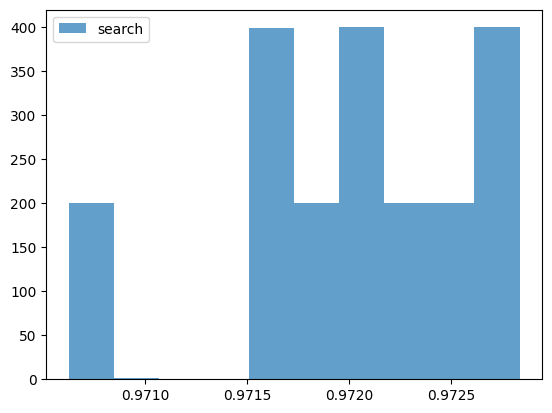

In [466]:
plt.hist(search_results[:,1], bins=10, alpha=.7, label='search')
# plt.hist(eval_results, bins=20, alpha=.7, label='eval')
plt.legend()
# np.sort(search_results[:,1])
# search_results


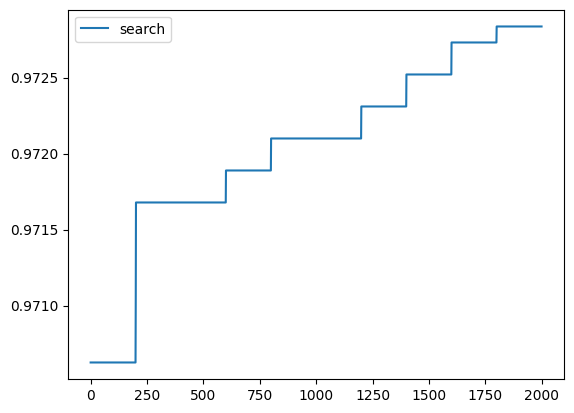

In [467]:
plt.plot(np.sort(search_results[:,1]), label='search')
# plt.plot(np.sort(eval_results), label='eval')
plt.legend()

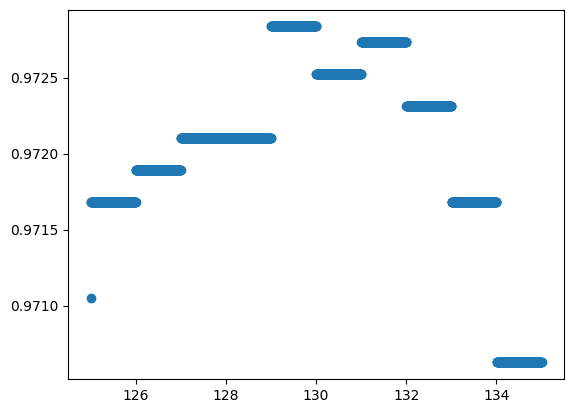

In [468]:
n = 1000000
plt.scatter(search_results[:n,0],search_results[:n,1])
# plt.scatter(search_results[:n,0],eval_results[:n])

In [469]:
np.argmax(search_results[:,1])
index = np.argsort(search_results[:,1])
search_results[index]

array([[1.35e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       [1.34e+02,  0.971],
       ...,
       [1.29e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973],
       [1.3e+02,  0.973]])